<a href="https://colab.research.google.com/github/ashikshafi08/Fingerprint_restoration_with_MIRNet/blob/main/Training_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive._mount('/content/drive/')

Mounted at /content/drive/


In [7]:
# Training data 
!wget http://158.109.8.102/Inpainting/Track3/training_input.zip
!wget http://158.109.8.102/Inpainting/Track3/training_ground-truth.zip

--2022-05-16 21:30:44--  http://158.109.8.102/Inpainting/Track3/training_input.zip
Connecting to 158.109.8.102:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2579851470 (2.4G) [application/zip]
Saving to: ‘training_input.zip’

training_input.zip  100%[===================>]   2.40G  23.9MB/s    in 2m 5s   

2022-05-16 21:32:50 (19.6 MB/s) - ‘training_input.zip’ saved [2579851470/2579851470]

--2022-05-16 21:32:50--  http://158.109.8.102/Inpainting/Track3/training_ground-truth.zip
Connecting to 158.109.8.102:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2551253143 (2.4G) [application/zip]
Saving to: ‘training_ground-truth.zip’

training_ground-tru 100%[===================>]   2.38G  7.13MB/s    in 2m 29s  

2022-05-16 21:35:19 (16.4 MB/s) - ‘training_ground-truth.zip’ saved [2551253143/2551253143]



In [ ]:
# !unzip training_input.zip -d /content/drive/MyDrive/FingerPrint
# !unzip training_ground-truth.zip -d /content/drive/MyDrive/FingerPrint

In [9]:
import glob
import os 
 # Data paths 

train_input_path = '/content/drive/MyDrive/FingerPrint/training_input/'
train_ground_path = '/content/drive/MyDrive/FingerPrint/training_ground-truth/'

#val_input_path = '/content/drive/MyDrive/final_year/validation_input/'
#val_ground_path = '/content/drive/MyDrive/final_year/validation_ground-truth/'

In [101]:
trainInputPaths = sorted(glob.glob(os.path.join(train_input_path , '*.jpg')))[:8000]
trainGroundPaths = sorted(glob.glob(os.path.join(train_ground_path , '*.jpg')))[:8000]


valInputPaths = sorted(glob.glob(os.path.join(train_input_path , '*.jpg')))[8000:9000]
valGroundPaths = sorted(glob.glob(os.path.join(train_ground_path , '*.jpg')))[8000:9000]


In [102]:
len(trainInputPaths) , len(trainGroundPaths) , len(valInputPaths) , len(valGroundPaths)

(8000, 8000, 1000, 1000)

In [103]:
# Random crop function from the tensorflow 

def tf_random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[124, 124, 3])

  return cropped_image

def read_image(image_path):

  '''
  image_path : path of the image 

  '''

  image = tf.io.read_file(image_path) # read the path 
  image = tf.image.decode_jpeg(image , channels = 3) # decode into jpeg  
  image = tf.image.resize(image , [128 , 128]) # resize the image 
  return image

In [104]:
# Function to load the data and apply the transforms 

def load_data(noise_image_path , truth_image_path):

  noise_image = read_image(noise_image_path)
  truth_image = read_image(truth_image_path)

  #cropped_noise_image = tf_random_crop(noise_image)
  #cropped_truth_image = tf_random_crop(truth_image)

  return noise_image , truth_image


In [123]:

# Setting up the parameters 
IMAGE_SIZE = 128
BATCH_SIZE = 16

In [106]:
# Function to make the tf.data.Dataset 
import tensorflow as tf

def get_dataset(noise_image_paths , truth_image_paths):

  dataset = tf.data.Dataset.from_tensor_slices((noise_image_paths , truth_image_paths))

  # Need to apply the transforms 
  dataset = dataset.map(load_data , num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE , drop_remainder= True).cache().prefetch(tf.data.AUTOTUNE)
  
  return dataset

In [107]:
# Creating the dataset 
from tensorflow.keras import layers 

train_dataset = get_dataset(trainInputPaths , trainGroundPaths)
val_dataset = get_dataset(valInputPaths , valGroundPaths)

print(f'Train Dataset --> {train_dataset}')
print('\n')
print(f'Val Dataset --> {val_dataset}')

Train Dataset --> <PrefetchDataset element_spec=(TensorSpec(shape=(8, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 128, 128, 3), dtype=tf.float32, name=None))>


Val Dataset --> <PrefetchDataset element_spec=(TensorSpec(shape=(8, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 128, 128, 3), dtype=tf.float32, name=None))>


In [108]:
def selective_kernel_feature_fusion(multi_scale_feature_1 , 
                                    multi_scale_feature_2 , multi_scale_feature_3):
  

  '''
  Performs multi-scale aggregation of the features
  '''

  ##### Fuse Operator ######
  ##########################

  # Shape of the multi-scale shape == number of channels
  channels = list(multi_scale_feature_1.shape)[-1]

  # Combining the feature by element wise summation 
  # L = L1 + L2 + L3
  combined_features = layers.Add()([multi_scale_feature_1 , multi_scale_feature_2 , multi_scale_feature_3])
                                  

  # Passing the L to the global averale pooling and compute across spatial dimension (HxW)
  gap = layers.GlobalAveragePooling2D()(combined_features)

  # Channel-wise statistics (s) [1x1xC] 
  channel_wise_stats = tf.reshape(gap , shape = (-1 , 1 , 1 , channels))

  # Channel downscaling cnn to generate compact feature representation 
  # r = C / 8 
  compact_feature_representation = layers.Conv2D(filters = channels // 8 , kernel_size = (1 , 1 )  , activation = 'relu')(channel_wise_stats)

  # Applying the PRelu for the above 
  #pRelu = layers.PReLU()(compact_feature_representation)


  ##### Select Operator ######
  ############################ 

  # Here we parse out each feature descriptors and apply softmax to them 
  feature_descriptor_1 = layers.Conv2D(
      filters = channels , kernel_size = (1,1) , activation = 'softmax'
  )(compact_feature_representation)
  feature_descriptor_2 = layers.Conv2D(
      filters = channels , kernel_size = (1 ,1) , activation = 'softmax'
  )(compact_feature_representation)
  feature_descriptor_3 = layers.Conv2D(
      channels , kernel_size = (1 , 1) , activation = 'softmax'
  )(compact_feature_representation)

  # Now we get the features by rescaling it 
  # input tensor * feature descriptor 
  feature_1 = multi_scale_feature_1 * feature_descriptor_1 # s1 * L1 
  feature_2 = multi_scale_feature_2 * feature_descriptor_2 # s2 * L2 
  feature_3 = multi_scale_feature_3 * feature_descriptor_3 # s3 * L3

  # U = L1*s1 + s2*L2 + s3*L3
  # This is the overall process of feature recali and aggregation 
  aggregated_feature = layers.Add()([feature_1 , feature_2 , feature_3])

  return aggregated_feature

In [109]:
# Lets build a function for the spatial attention block 

def spatial_attention_block(input_tensor):

  average_pooling = tf.reduce_mean(input_tensor  , axis = -1)
  average_pooling = tf.expand_dims(average_pooling , axis = -1)

  max_pooling = tf.reduce_max(input_tensor , axis = -1)
  max_pooling = tf.expand_dims(max_pooling , axis = -1)

  

  # Performing the C 
  # Concatenate by the last axis
  concatenation = layers.Concatenate(axis = -1)([average_pooling , max_pooling])

  # Passing the feature map [HXWx2] into a CNN
  feature_map = layers.Conv2D(1 , kernel_size = (1 ,1 ))(concatenation)

  # Appling sigmoid function to the feature map 
  feature_map = tf.nn.sigmoid(feature_map)

  # F cap * M 
  return input_tensor * feature_map


In [110]:
# Function for the channel attention block 

def channel_attention_block(input_tensor):

  channels = list(input_tensor.shape)[-1]

  # Applying the GAP 
  average_pooling = layers.GlobalAveragePooling2D()(input_tensor)

  # Reshaping of shape (1x1xC) for the feature descriptor 
  feature_descriptor = tf.reshape(average_pooling , shape = (-1 , 1 , 1, channels)) # 1x1xC

  # r = C / 8 
  feature_activations = layers.Conv2D(
      filters = channels // 8 , kernel_size = (1 , 1)  , activation = 'relu')(feature_descriptor)

 # pRelu = layers.PReLU()(feature_activations)

  sigFeature_activations = layers.Conv2D(channels , kernel_size = (1 ,1 ) , activation = 'sigmoid')(feature_activations)

  # Rescaling the features 
  return input_tensor * sigFeature_activations

In [111]:
# Constructing the Dual Attention Block 

def dual_attention_unit_block(input_tensor):

  channels = list(input_tensor.shape)[-1]

  feature_map = layers.Conv2D(channels , kernel_size = (3,3) , padding = 'same' , activation= 'relu')(input_tensor)
  #feature_map = layers.PReLU()(feature_map)
  
  feature_map = layers.Conv2D(channels , kernel_size = (3 ,3) , padding = 'same')(feature_map)

  # Configuring the channel attention and spatial attention 
  channel_attention = channel_attention_block(feature_map)
  spatial_attention = spatial_attention_block(feature_map)

  # Performing the concat where we will combine both the attention maps 
  concat = layers.Concatenate(axis = -1)([channel_attention , spatial_attention])
  
  # Applying a final Conv layer 
  concat = layers.Conv2D(channels , kernel_size = (1 , 1))(concat)

  # Rescaling the output with the input tensor 
  rescaleFeature = layers.Add()([input_tensor , concat])

  return rescaleFeature


In [112]:
# Downsampling module

def downsample_module(input_tensor):

  # color channels 
  channels = list(input_tensor.shape)[-1]

  # First Conv + PReLU combo 
  main_branch = layers.Conv2D(channels , kernel_size = (1 , 1) , activation= 'relu')(input_tensor)
  #main_branch = layers.PReLU()(main_branch)

  # Conv2D 3 kernel and PRelu 
  main_branch = layers.Conv2D(channels , kernel_size = (3 ,3), padding = 'same' , activation= 'relu')(main_branch)
  #main_branch = layers.PReLU()(main_branch)

  # Antialiasing down sampling is nothing but a maxpooling 
  main_branch = layers.MaxPooling2D()(main_branch)


  #### Performing 2x downsampling ####
  ####################################

  # Conv2D 1 kernel 
  main_branch = layers.Conv2D(channels * 2 , kernel_size = (1, 1))(main_branch)


  ## Skip Connection 

  # Another Anti aliasing and Conv2D downsample (skip branch)
  skip_branch = layers.MaxPooling2D()(input_tensor)
  skip_branch = layers.Conv2D(channels * 2 , kernel_size = (1 ,1))(skip_branch)

  skip_connection = layers.Add()([skip_branch , main_branch])

  return skip_connection


# Upsampling module 

def upsampling_module(input_tensor):

  channels = list(input_tensor.shape)[-1]

  main_branch = layers.Conv2D(channels  , kernel_size = (1, 1) , activation = 'relu')(input_tensor)
  #main_branch = layers.PReLU()(main_branch)

  main_branch = layers.Conv2D(channels , kernel_size = (3 ,3), padding ='same' , activation= 'relu')(main_branch)
  #main_branch = layers.PReLU()(main_branch)

  # Performing the Bilinear Upsampling and passing into a Conv2D layer
  main_branch = layers.UpSampling2D()(main_branch)
  main_branch = layers.Conv2D(channels // 2 , kernel_size = (1 ,1))(main_branch)

  #### Skip Conection #### 

  skip_branch = layers.UpSampling2D()(input_tensor)
  skip_branch = layers.Conv2D(channels // 2 , kernel_size = (1, 1))(skip_branch)

  skip_connection = layers.Add()([skip_branch , main_branch])
  return skip_connection

In [113]:
# Constructing the MRB Block 

def multi_scale_residual_block(input_tensor , channels):

  ##### Feature Maps ######
  ######################### 

  level_1 = input_tensor
  level_2 = downsample_module(input_tensor) # 2 X down sampling 
  level_3 = downsample_module(level_2) # 4 x down sampling 

  #### Passing into DAU Blocks ####
  #################################

  level_1_dau = dual_attention_unit_block(level_1)
  level_2_dau = dual_attention_unit_block(level_2)
  level_3_dau = dual_attention_unit_block(level_3)

  ###### Passing the output Features from DAU to SKFF with different scalings ########
  ####################################################################################

  # SKFF for the level 1,2,3 output from DAU 
  # Got doubts on this -> mail or reach out to the author
  level_1_skff  = selective_kernel_feature_fusion(level_1_dau , upsampling_module(level_2_dau) , 
                                                  upsampling_module(upsampling_module(level_3_dau)))
  
  level_2_skff = selective_kernel_feature_fusion(downsample_module(level_1_dau) , 
                                                 level_2_dau , upsampling_module(level_3_dau))
  
  level_3_skff = selective_kernel_feature_fusion(downsample_module(downsample_module(level_1_dau)) , 
                                                 downsample_module(level_2_dau) , 
                                                 level_3_dau)
  
  # Passing the skff features to DAU again and applying the scaling 
  level_1_dau2 = dual_attention_unit_block(level_1_skff)
  level_2_dau2 = upsampling_module(dual_attention_unit_block(level_2_skff))
  level_3_dau2 = upsampling_module(upsampling_module(dual_attention_unit_block(level_3_skff)))  


  # Atlast passing everything into a skff 
  skff_ = selective_kernel_feature_fusion(level_1_dau2 , level_2_dau2 , level_3_dau2) # TK: Doubt 

  # A conv layer 
  conv = layers.Conv2D(channels , kernel_size = (3 ,3) , padding ='same')(skff_)

  # Residual connection 
  output = layers.Add()([input_tensor ,  conv])
  return output

In [114]:
def recursive_residual_group(input_tensor , number_of_mrb, channels):

  # First conv layer 
  conv_1 = layers.Conv2D(channels , kernel_size = (3 ,3) , padding = 'same')(input_tensor)

  # For P number of MRBs 
  for _ in range(number_of_mrb):
    conv_1 = multi_scale_residual_block(conv_1 , channels)

  conv_2 = layers.Conv2D(channels , kernel_size= (3,3) , padding = 'same')(conv_1)

  return layers.Add()([conv_2 , input_tensor])


In [116]:
def mirnet_model(number_of_rrg , number_of_mrb , channels):

  # Getting the input tensor of image 
  input_tensor = tf.keras.Input(shape = (128 , 128 , 3))

  # First Conv layer (X0)
  x1 = layers.Conv2D(channels , kernel_size = (3 ,3) , padding = 'same')(input_tensor)

  # Looping into the N number of RRGs 
  for _ in range(number_of_rrg):

    x1 = recursive_residual_group(x1 , number_of_mrb , channels)

  # Applying the Conv layer on Xd
  conv = layers.Conv2D(3 , kernel_size = (3 ,3) , padding ='same')(x1)

  # Skip connection to the I cap 
  output_tensor = layers.Add()([input_tensor , conv])

  # Pack this into a model 
  model = tf.keras.Model(input_tensor , output_tensor)

  return model

In [119]:
# Lets create model 

model = mirnet_model(2 , 2 , channels = 64)

In [120]:
# Defining the loss functions 
def charbonnier_loss(y_true , y_pred):
  loss =  tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3))) # reduce mean because we are computing in batches 
  return loss

# Metrics to calculate the psnr ratio. 
def peak_signal_noise_ratio(y_true , y_pred):
  return tf.image.psnr(y_pred , y_true , max_val = 255.0)

def structual_similarity_index(y_true , y_pred):
  return tf.image.ssim(y_pred , y_true , max_val = 255.0)

In [126]:
# Compiling the model 

optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4)

model.compile(optimizer = optimizer , loss = charbonnier_loss , 
              metrics = [peak_signal_noise_ratio , structual_similarity_index])

In [ ]:
history = model.fit(train_dataset , 
                    validation_data = val_dataset , 
                    epochs = 5 )

Epoch 1/5
1000/1000 [==============================] - 851s 821ms/step - loss: 41.1488 - peak_signal_noise_ratio: 13.3827 - structual_similarity_index: 0.4607 - val_loss: 33.2238 - val_peak_signal_noise_ratio: 14.3772 - val_structual_similarity_index: 0.5689
Epoch 2/5
 107/1000 [==>...........................] - ETA: 11:40 - loss: 32.5842 - peak_signal_noise_ratio: 14.5490 - structual_similarity_index: 0.5813

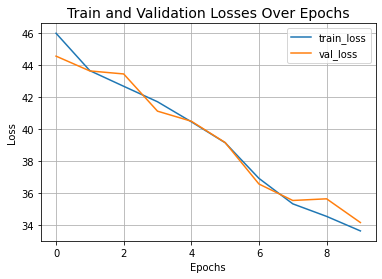

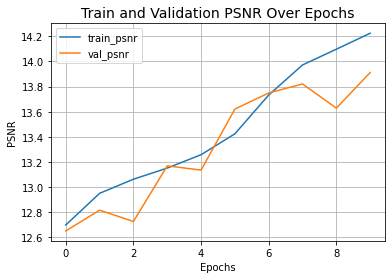

In [51]:
import matplotlib.pyplot as plt


plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

print('\n \n')


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [49]:
# Visualizing the inference images 

def plot_results(images , titles , figure_size = (12 ,12)):

  fig = plt.figure(figsize = (figure_size))
  for i in range(len(images)):
    fig.add_subplot(1 , len(images) , i + 1).set_title(titles[i])
    _ = plt.imshow(images[i])
    plt.axis('off')
  plt.show()

# Get the prediction 

from PIL import Image , ImageOps

def infer_image(original_image):
  image = tf.keras.preprocessing.image.img_to_array(original_image)
  image = tf.image.resize(image , size = [124 , 124])
  #image = image.astype('float32') / 255.0
  image = tf.expand_dims(image , axis = 0)
  output = model.predict(image)

  output_image = output[0] * 255.0
  output_image = output_image.clip(0 , 255)
  output_image = output_image.reshape(
      (np.shape(output_image)[0] , np.shape(output_image)[1] , 3)
  )

  output_image = Image.fromarray(np.uint8(output_image))
  original_image = Image.fromarray(np.uint8(original_image))

  return output_image

In [70]:
# Get the prediction 

from PIL import Image , ImageOps

def infer_image(original_image):
  image = tf.keras.preprocessing.image.img_to_array(original_image)
  image = tf.image.resize(image , size = [124 , 124])
  #image = image.astype('float32') / 255.0
  image = tf.expand_dims(image , axis = 0)
  output = model.predict(image)

  output_image = output[0] * 255.0
  output_image = output_image.clip(0 , 255)
  output_image = output_image.reshape(
      (np.shape(output_image)[0] , np.shape(output_image)[1] , 3)
  )

  output_image = Image.fromarray(np.uint8(output_image))
  original_image = Image.fromarray(np.uint8(original_image))

  return output_image

In [ ]:
import random 
import numpy as np 

for noiseImage in random.sample(valInputPaths , 6):
  original_image = Image.open(noiseImage)
  restored_image = infer_image(original_image)

  plot_results(
      [original_image , ImageOps.autocontrast(original_image) , restored_image] , 
      ['Original' , 'PIL Auto Contrast' , 'MIRNet Restored'] , 
      (20 , 12)
  )

In [79]:
randomPath = random.choice(valInputPaths)

img = read_image(randomPath)
img.shape

TensorShape([124, 124, 3])

In [84]:

imgArr = tf.keras.utils.img_to_array(img)
imgArr = tf.expand_dims(imgArr , axis = 0)
imgArr.shape

TensorShape([1, 124, 124, 3])

In [91]:
predImg = model.predict(imgArr)

predImg = predImg[0] * 255.0 
pred_img = predImg.clip(0 , 255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


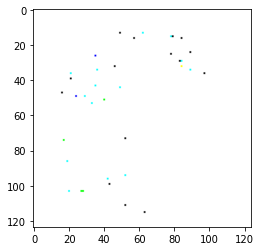

In [92]:
plt.imshow(pred_img)